In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from matplotlib_venn import venn2

from utils import enrich, enrichr

In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
2022-06-27 15:12:57.381488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 15:12:57.381669: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.5.3 pandas==1.3.4 scikit-learn==1.0.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.5


## Load datasets

We're mapping between:
1. Our dataset (ALI)
2. Heumos et al. mouse epithelium over time
3. Melms et al. covid patient resections (?)
4. Fischer et al. covid patient resections

In [75]:
ALI = sc.read_h5ad('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211015_annot_patient_integrated.h5ad')
# remove nans
ALI = ALI[ALI.obs.treatment != 'nan']
ALI

View of AnnData object with n_obs × n_vars = 221974 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', 'celltype_fine'
    var: 'used_for_scvi'
    uns: '_scvi', 'cell_type_colors', 'celltype_fine_colors', 'hvg', 'infected_colors', 'leiden', 'neighbors', 'patient_colors', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

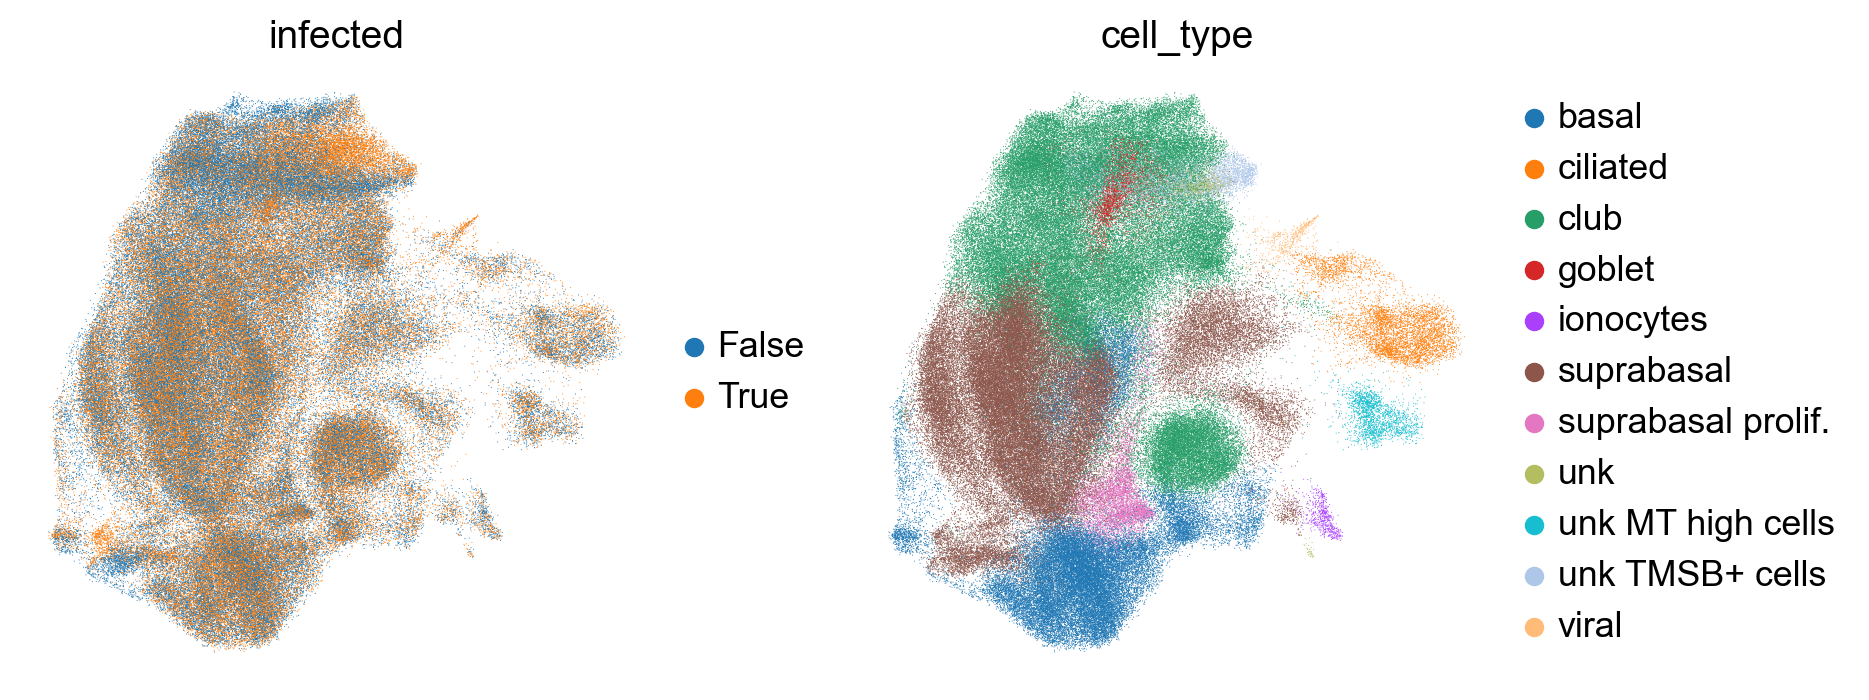

In [77]:
sc.pl.umap(ALI, color=['infected', 'cell_type'])

In [58]:
heumos = sc.read('/home/icb/lukas.heumos/yuge_mhv68/2022_03_09_annotated.h5ad')
heumos.obs['mut_status'] = heumos.obs['batch']  # clarify variable
# subset to lung epithelium
heumos = heumos[heumos.obs.super_cell_type == 'epithelium'].copy()
# change to human names
heumos.var_names = pd.Series(heumos.var_names).str.upper().values
heumos

AnnData object with n_obs × n_vars = 5766 × 20379
    obs: 'identifier', 'grouping', 'batch', 'name', 'sex', 'n_counts', 'n_genes', 'percent.mito', 'percent.viral', 'S_score', 'G2M_score', 'phase', 'louvain', 'days', 'pseudotime', 'spline_types', 'Spline Type', 'Celltype group', 'days_numeric', 'celltype_refined', 'infected', 'viral_cat', 'gt_viralcat', 'gt_celltype', 'leiden_1', 'leiden_1_5', 'leiden_2', 'super_cell_type', 'cell_type', 'group', 'de_cell_type_group', 'de_grouping', 'mut_status'
    var: 'n_cells', 'highly_variable', 'n_counts', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'Celltype group_colors', 'Spline Type_colors', 'batch_colors', 'cell_type_ranks', 'celltype_refined_colors', 'days_colors', 'dendrogram_cell_type', 'grouping_colors', 'gt_celltype_colors', 'gt_viralcat_colors', 'leiden', 'leiden_1_5_colors', 'leiden_1_colors', 'leiden_2_colors', 'louvain', 'name_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_r1', 'rank_genes_r1_5', 'rank

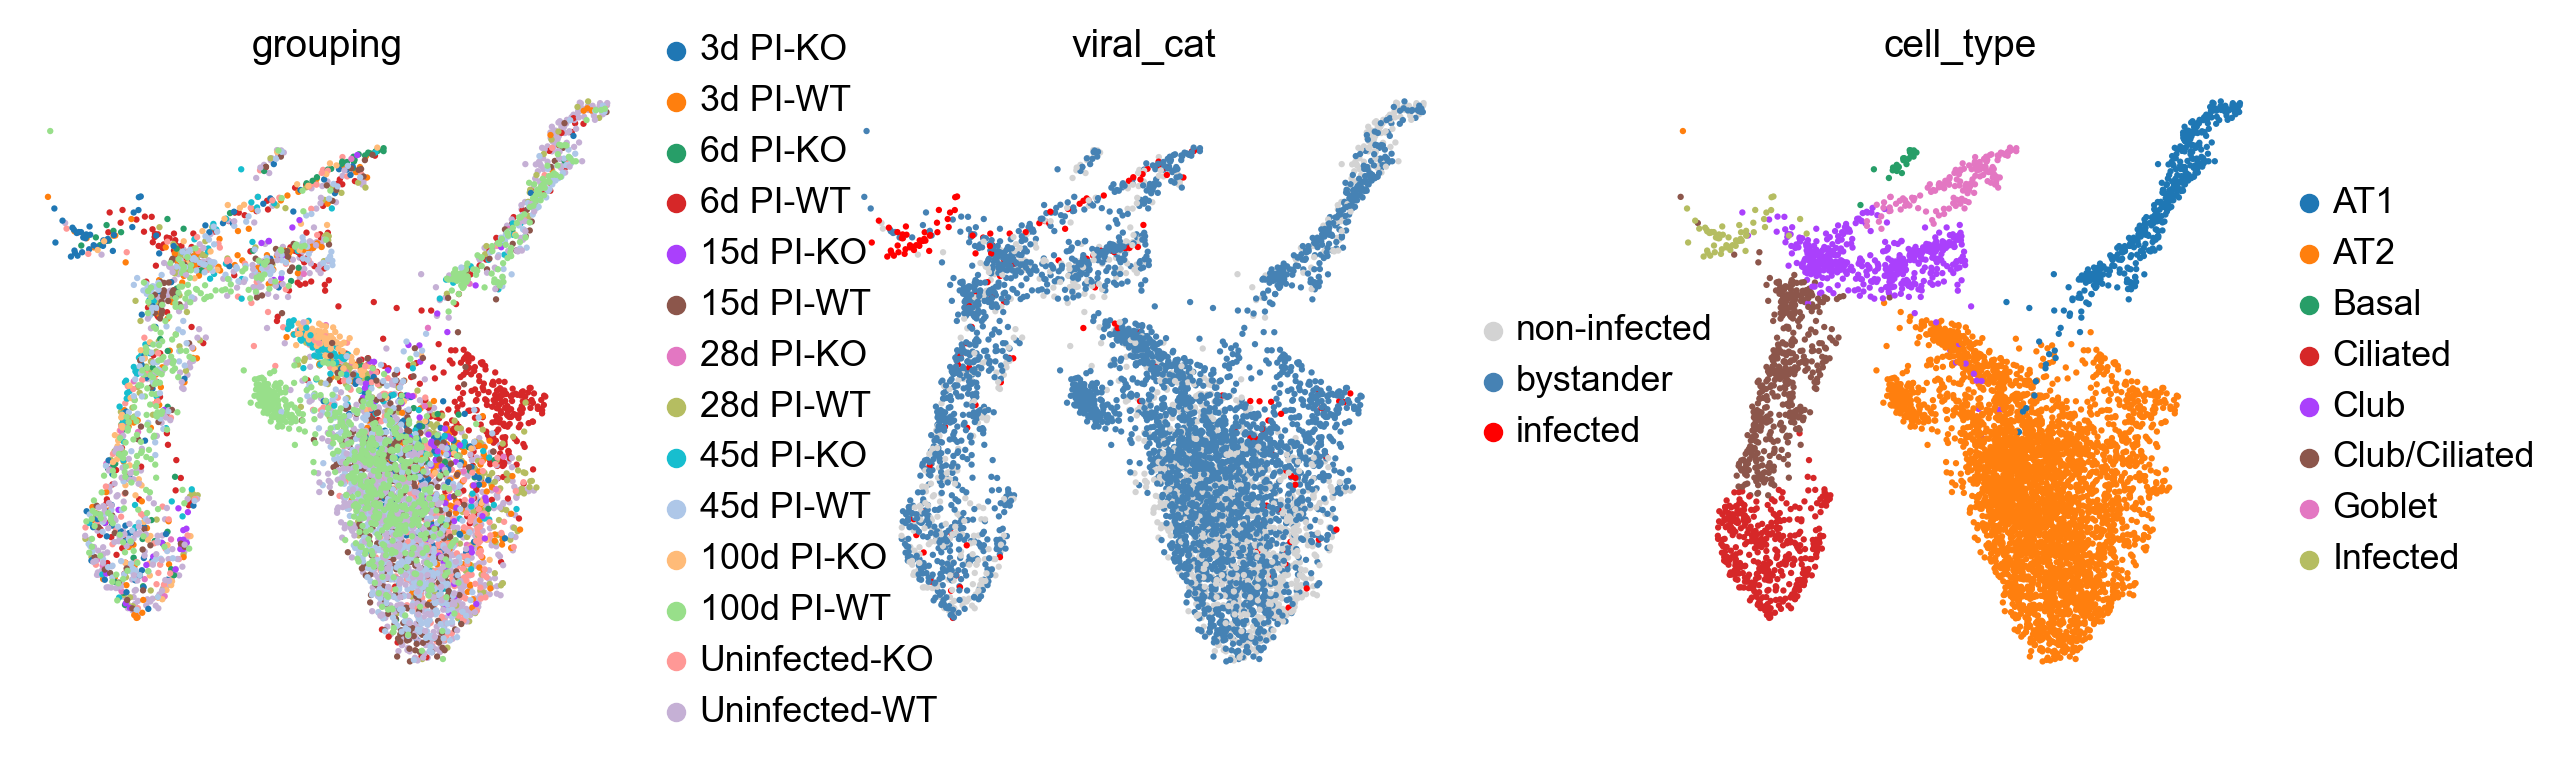

In [59]:
sc.pl.umap(heumos, color=['grouping', 'viral_cat', 'cell_type'])

In [11]:
melms = sc.read('melms2021/Melms_2021.h5ad')
# subset to epithelial
melms = melms[melms.obs.cell_type_main == 'Epithelial cells'].copy()
melms

AnnData object with n_obs × n_vars = 30069 × 34546
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'group', 'cell_type_main', 'cell_type_intermediate', 'cell_type_fine', 'initial_clustering', 'age', 'sex', 'recorded_race', 'recorded_ethnicity', 'intubation_days', 'interval_death_symptoms_onset_days', 'pmi_h', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'biosample_id_colors', 'cell_type_fine_colors', 'cell_type_intermediate_colors', 'cell_type_main_colors', 'disease__ontology_label_colors', 'disease_colors', 'donor_id_colors', 'group_colors', 'hvg', 'leiden', 'library_preparation_protocol__ontology_label_colors', 'library_preparation_protocol_colors', 'neighbors', 'organ__ontology_label_colors', 'organ_colors', 'pca', 'recorded_ethnicity_colors', 'recorded_race_color

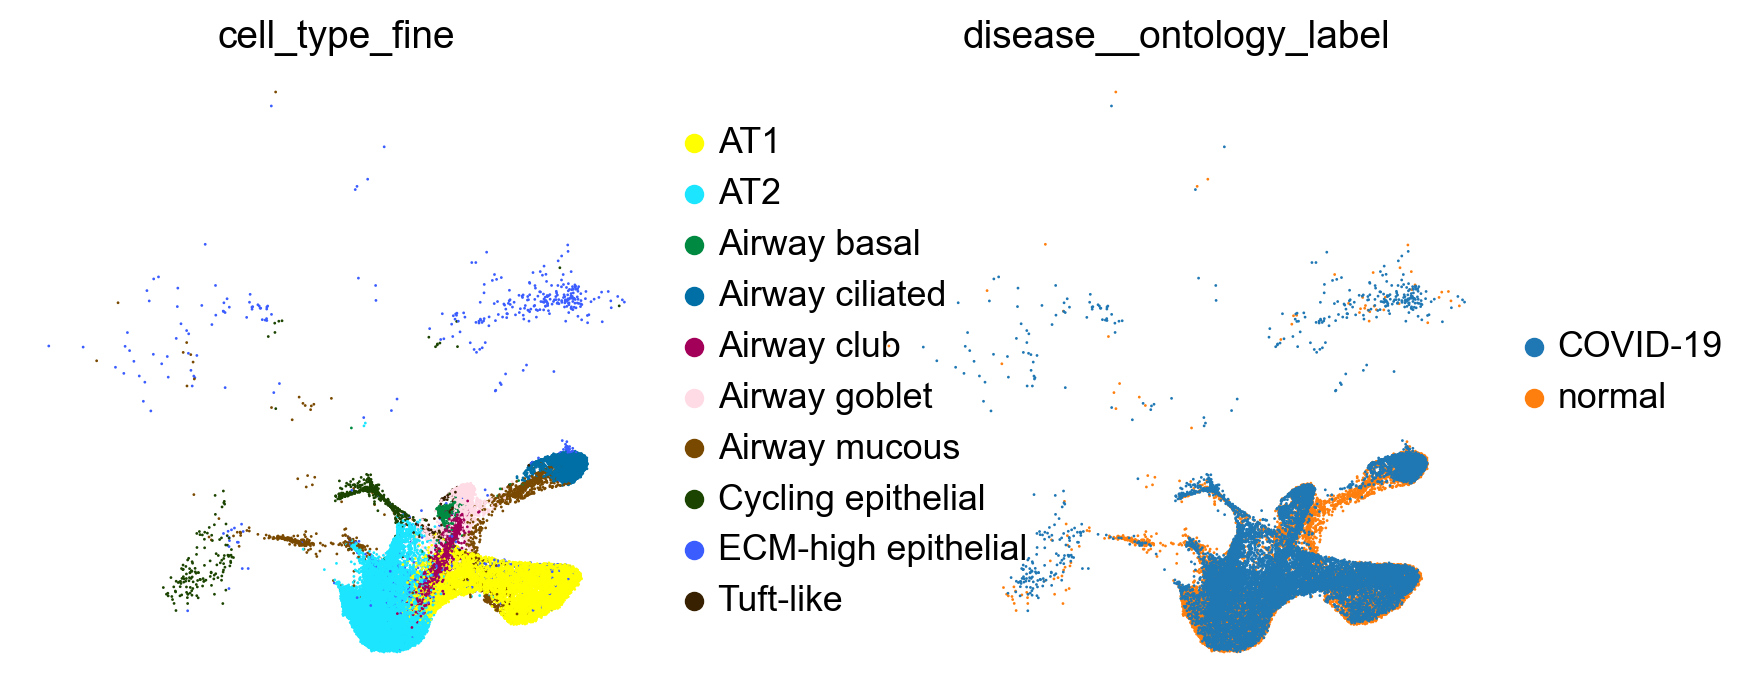

In [13]:
sc.pl.umap(melms, color=['cell_type_fine', 'disease__ontology_label'])

In [17]:
fischer = sc.read('/storage/groups/ml01/datasets/projects/20201130_Schober_TcellReversePhenotyping_meshal.ansari/201209_TcellReversePT_integrated.h5ad')
fischer.obs['cell_type'] = ['('.join(s.split('(')[:-1])[:-1] for s in fischer.obs['harmonized_celltype'].values]
# subset to epithelial cell types
fischer = fischer[fischer.obs.cell_type.isin(['Ciliated', 'Ciliated diff.', 'Basal', 'Ionocytes', 'Squamous epithelial', 'Secretory', 'AT2, AT1 cells'])]
fischer

View of AnnData object with n_obs × n_vars = 62326 × 46190
    obs: 'patients', 'sample_ID', 'data_set', 'severity', 'location', 'condition', 'age', 'sex', 'virus_positive', 'PBMC_leiden_29', 'patient_category', 'reactive_clonotype', 'published_meta_celltype', 'published_celltype', 'harmonized_celltype', 'T_cell_type', 'size_factors', 'pct_mitochondrial', 'n_counts', 'n_genes', 'cell_type'
    var: 'highly_variable'
    uns: 'PBMC_leiden_29_colors', 'T_cell_type_colors', 'condition_colors', 'data_set_colors', 'harmonized_celltype_colors', 'leiden_colors', 'location_colors', 'name_colors', 'neighbors', 'patient_category_colors', 'patient_colors', 'patients_colors', 'pca', 'published_celltype_colors', 'reactive_colors', 'sample_colors', 'second_harmonized_colors', 'severity_TA_colors', 'severity_colors', 'severity_condition_colors', 'umap', 'virus_positive_colors'
    obsm: 'X_clonotype_network', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connect

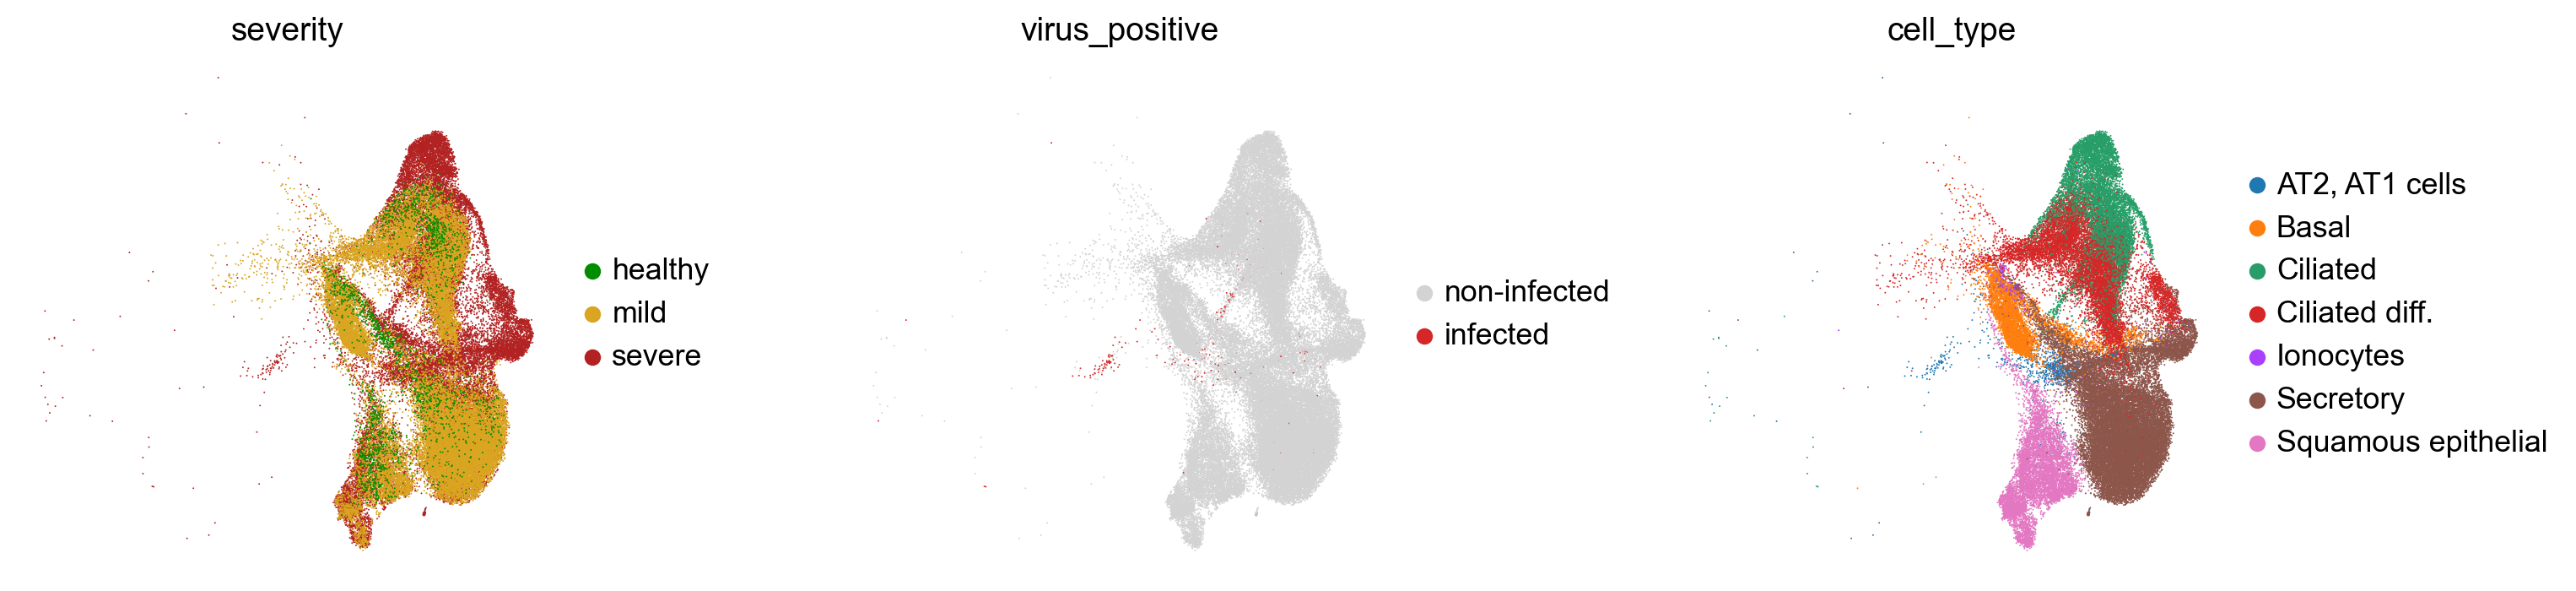

In [20]:
sc.pl.umap(fischer, color=['severity', 'virus_positive', 'cell_type'], wspace=.4)

In [97]:
datasets = {
    'ALI': {
        'infection_label':'infected',
        'ref':'False',
        'target':'True',
        'adata':ALI,
    },
    'heumos':{
        'infection_label':'days',
        'ref':'Uninfected',
        'target':'6d',
        'adata':heumos,
    },
    'melms':{
        'infection_label':'disease__ontology_label',
        'ref':'normal',
        'target':'COVID-19',
        'adata':melms,
    },
    'fischer (mild)':{
        'infection_label':'severity',
        'ref':'healthy',
        'target':'mild',
        'adata':fischer,
    },
    'fischer (severe)':{
        'infection_label':'severity',
        'ref':'healthy',
        'target':'severe',
        'adata':fischer,
    }
}

## plot differential expression

In [98]:
for k, v in datasets.items():
    sc.tl.rank_genes_groups(v['adata'], groupby=v['infection_label'], reference=v['ref'])
    v['df'] = sc.get.rank_genes_groups_df(v['adata'], group=v['target'])

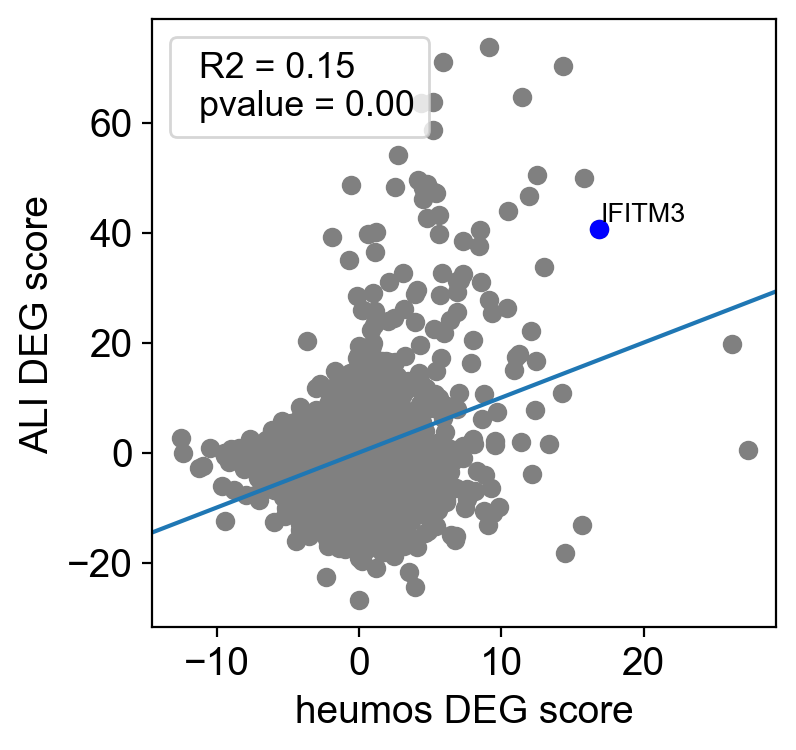

,scores_ALI,logfoldchanges_ALI,pvals_ALI,pvals_adj_ALI,scores_heumos,logfoldchanges_heumos,pvals_heumos,pvals_adj_heumos,margin,expr
names,,,,,,,,,,
IFITM3,40.639992,0.302373,0.0,0.0,16.860262,3.943905,2.089528e-52,5.730271e-49,23.77973,28.750126


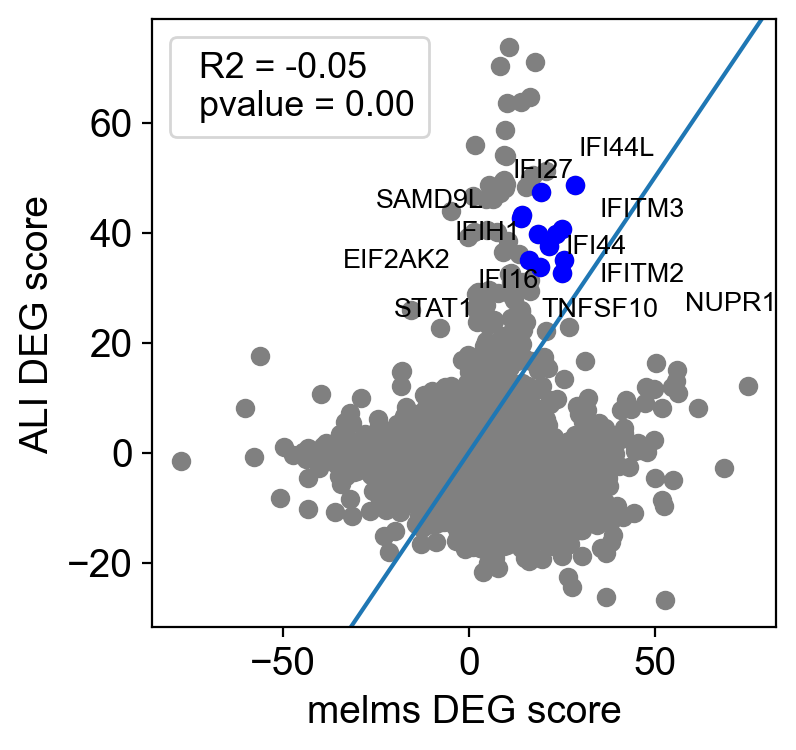

,scores_ALI,logfoldchanges_ALI,pvals_ALI,pvals_adj_ALI,scores_melms,logfoldchanges_melms,pvals_melms,pvals_adj_melms,margin,expr
names,,,,,,,,,,
IFI44L,48.728142,0.545415,0.000000e+00,0.000000e+00,28.528357,2.718749,4.436446e-175,6.577746e-173,20.199785,38.628250
IFI27,47.461029,0.488311,0.000000e+00,0.000000e+00,19.497501,2.688865,8.989495e-84,4.573654e-82,27.963528,33.479263
SAMD9L,43.268173,0.612692,0.000000e+00,0.000000e+00,14.247629,1.106274,7.023710e-46,1.674542e-44,29.020544,28.757900
IFIH1,42.738647,0.609747,0.000000e+00,0.000000e+00,14.150454,1.366041,2.871849e-45,6.717054e-44,28.588194,28.444550
IFITM3,40.639992,0.302373,0.000000e+00,0.000000e+00,25.207756,3.559904,1.508879e-137,1.489307e-135,15.432236,32.923874
EIF2AK2,39.825073,0.388690,0.000000e+00,0.000000e+00,18.522100,1.026080,4.308597e-76,1.966245e-74,21.302973,29.173588
IFITM2,39.695892,0.407150,0.000000e+00,0.000000e+00,23.411512,4.705944,4.492012e-119,3.542947e-117,16.284380,31.553703
IFI44,37.564434,0.472690,7.983440e-308,3.805790e-305,21.592583,1.923217,2.921018e-102,1.911164e-100,15.971851,29.578508
IFI16,35.075462,0.233482,8.776715e-269,3.877810e-266,16.285778,1.216195,2.592976e-59,8.596638e-58,18.789684,25.680620


,name,p_value,intersections
0,response to virus,1.022735e-10,"[IFI44L, IFI27, IFIH1, IFITM3, EIF2AK2, IFITM2..."
1,defense response to virus,3.571698e-10,"[IFI44L, IFI27, IFIH1, IFITM3, EIF2AK2, IFITM2..."
2,defense response to symbiont,3.571698e-10,"[IFI44L, IFI27, IFIH1, IFITM3, EIF2AK2, IFITM2..."
3,negative regulation of viral process,2.718020e-09,"[IFIH1, IFITM3, EIF2AK2, IFITM2, IFI16, STAT1]"
4,viral genome replication,2.103279e-08,"[IFI27, IFIH1, IFITM3, EIF2AK2, IFITM2, IFI16]"


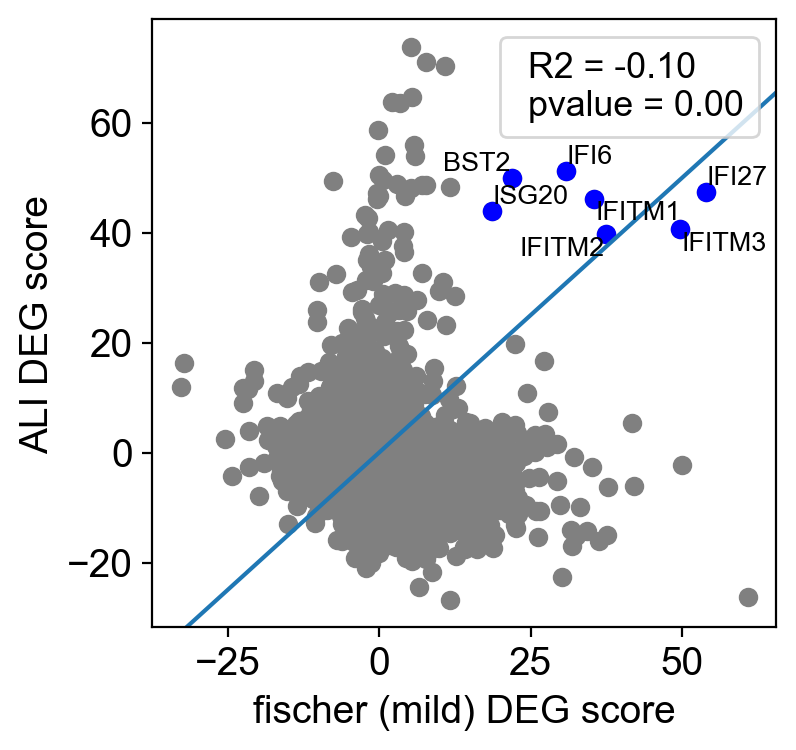

,scores_ALI,logfoldchanges_ALI,pvals_ALI,pvals_adj_ALI,scores_fischer (mild),logfoldchanges_fischer (mild),pvals_fischer (mild),pvals_adj_fischer (mild),margin,expr
names,,,,,,,,,,
BST2,49.964550,0.507574,0.0,0.0,21.845169,1.548463,5.068233e-99,3.494055e-96,28.119381,35.904861
IFI27,47.461029,0.488311,0.0,0.0,53.856731,2.129656,0.000000e+00,0.000000e+00,6.395702,50.658882
IFI6,51.195408,0.538738,0.0,0.0,30.845808,2.027109,1.667812e-186,3.349401e-183,20.349600,41.020607
IFITM1,46.202885,0.760598,0.0,0.0,35.504501,3.218426,4.400547e-258,2.258458e-254,10.698383,40.853691
IFITM2,39.695892,0.407150,0.0,0.0,37.501778,4.444371,1.224632e-295,8.080823e-292,2.194115,38.598835
IFITM3,40.639992,0.302373,0.0,0.0,49.586605,2.577837,0.000000e+00,0.000000e+00,8.946613,45.113297
ISG20,43.908035,0.467254,0.0,0.0,18.548687,1.601256,3.707366e-73,1.556757e-70,25.359348,31.228361


,name,p_value,intersections
0,defense response to virus,3.808623e-11,"[BST2, IFI27, IFI6, IFITM1, IFITM2, IFITM3, IS..."
1,defense response to symbiont,3.808623e-11,"[BST2, IFI27, IFI6, IFITM1, IFITM2, IFITM3, IS..."
2,viral genome replication,1.185737e-10,"[BST2, IFI27, IFITM1, IFITM2, IFITM3, ISG20]"
3,response to virus,1.426740e-10,"[BST2, IFI27, IFI6, IFITM1, IFITM2, IFITM3, IS..."
4,negative regulation of viral genome replication,4.029723e-10,"[BST2, IFITM1, IFITM2, IFITM3, ISG20]"


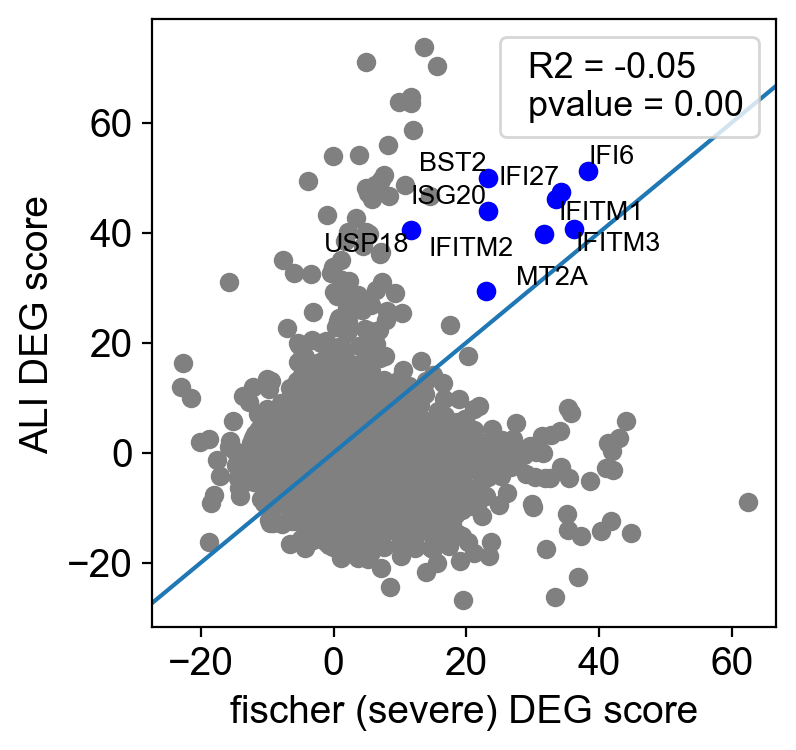

,scores_ALI,logfoldchanges_ALI,pvals_ALI,pvals_adj_ALI,scores_fischer (severe),logfoldchanges_fischer (severe),pvals_fischer (severe),pvals_adj_fischer (severe),margin,expr
names,,,,,,,,,,
BST2,49.964550,0.507574,0.000000e+00,0.000000e+00,23.297834,1.652940,1.594239e-112,1.022748e-109,26.666716,36.631191
IFI27,47.461029,0.488311,0.000000e+00,0.000000e+00,34.278656,1.535680,1.207552e-218,2.231073e-215,13.182373,40.869843
IFI6,51.195408,0.538738,0.000000e+00,0.000000e+00,38.278366,2.373166,8.041059e-280,3.376514e-276,12.917042,44.736885
IFITM1,46.202885,0.760598,0.000000e+00,0.000000e+00,33.532162,3.731188,3.678662e-241,8.943020e-238,12.670723,39.867523
IFITM2,39.695892,0.407150,0.000000e+00,0.000000e+00,31.700399,4.140867,1.863386e-213,3.187770e-210,7.995493,35.698147
IFITM3,40.639992,0.302373,0.000000e+00,0.000000e+00,36.161221,2.250793,1.638936e-257,5.046831e-254,4.478771,38.400604
ISG20,43.908035,0.467254,0.000000e+00,0.000000e+00,23.273409,1.929267,2.463381e-113,1.602586e-110,20.634626,33.590721
MT2A,29.333382,0.223990,8.974547e-189,3.126421e-186,22.978380,1.683411,5.053377e-109,3.031370e-106,6.355001,26.155880
USP18,40.418919,0.905451,0.000000e+00,0.000000e+00,11.659328,1.466719,5.603036e-31,3.670982e-29,28.759590,26.039124


,name,p_value,intersections
0,defense response to virus,1.556045e-09,"[BST2, IFI27, IFI6, IFITM1, IFITM2, IFITM3, IS..."
1,defense response to symbiont,1.556045e-09,"[BST2, IFI27, IFI6, IFITM1, IFITM2, IFITM3, IS..."
2,viral genome replication,1.638821e-09,"[BST2, IFI27, IFITM1, IFITM2, IFITM3, ISG20]"
3,negative regulation of viral genome replication,3.506292e-09,"[BST2, IFITM1, IFITM2, IFITM3, ISG20]"
4,response to virus,3.681939e-09,"[BST2, IFI27, IFI6, IFITM1, IFITM2, IFITM3, IS..."


In [100]:
from utils import plot_correlation, enrich

k1='ALI'
v1=datasets['ALI']
for k2, v2 in datasets.items():
    if k1 == k2:
        continue
    v1['df'] = sc.get.rank_genes_groups_df(v1['adata'], group=v1['target'])
    v2['df'] = sc.get.rank_genes_groups_df(v2['adata'], group=v2['target'])
    v1['df']['names'] = v1['df']['names'].str.upper().values
    v2['df']['names'] = v2['df']['names'].str.upper().values
    v1['df'] = v1['df'].set_index('names').add_suffix(f'_{k1}')
    v2['df'] = v2['df'].set_index('names').add_suffix(f'_{k2}')
    df = v1['df'].join(v2['df'], how='inner')

    high_corr = plot_correlation(df, f'scores_{k2}', f'scores_{k1}')
    plt.xlabel(f'{k2} DEG score')
    plt.ylabel(f'{k1} DEG score')
    plt.grid(b=False)
    plt.show()
    display(high_corr)
    if high_corr.shape[0] > 2:
        display(enrich(high_corr.index.values, df.index.values).head())